# Train Log 20181201

* Add multi-model training structure

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

# sys.path.append( os.path.abspath('../../../Dataset/scripts'))
# from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *

import multiprocessing

import tensorflow as tf


In [2]:
""" Path """
data_train_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/train.h5')
data_vali_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/vali.h5')


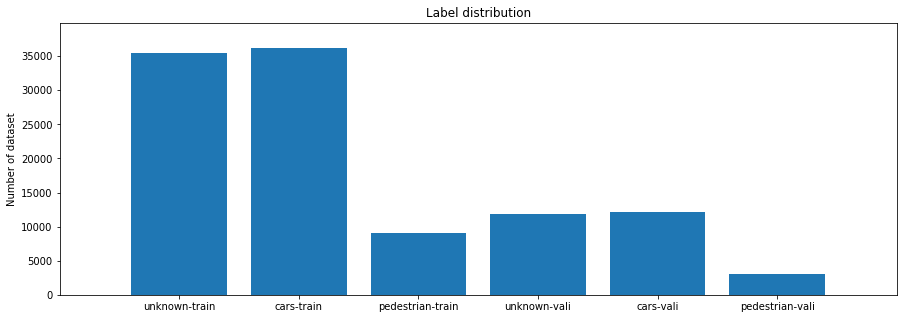

In [3]:
""" Load dataset"""

data = []
class_label = []
heading_label = []

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['class'][:]
    heading_label = f['heading'][:]
    return (data, class_label, heading_label)

data_train, class_label_train, heading_label_train = load_h5(data_train_path)
data_vali, class_label_vali, heading_label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
class_label.append(class_label_train)
class_label.append(class_label_vali)
heading_label.append(heading_label_train)
heading_label.append(heading_label_vali)

""" Data statistics """

label_list = [0,1,2]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(class_label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train','pedestrian-train',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=10)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            num_batches = 500
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_4',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-04 09:02:56.869336  

 Train one epoch   1 /  10


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


2018-12-04 09:05:58.182419  [Epoch 0] mean loss: 0.092675
2018-12-04 09:05:58.184429  [Epoch 0] heading rmse[deg]: 192.540236
2018-12-04 09:05:58.186204  [Epoch 0] class accuracy: 0.495440
2018-12-04 09:05:58.188131  [Epoch 0] avg class acc: 0.420862
2018-12-04 09:05:58.189847  [Epoch 0] indivisual [0] class recall: 0.463424
2018-12-04 09:05:58.191440  [Epoch 0] indivisual [0] class precision: 0.479092
2018-12-04 09:05:58.193069  [Epoch 0] indivisual [1] class recall: 0.598068
2018-12-04 09:05:58.194546  [Epoch 0] indivisual [1] class precision: 0.503996
2018-12-04 09:05:58.196095  [Epoch 0] indivisual [2] class recall: 0.201095
2018-12-04 09:05:58.197573  [Epoch 0] indivisual [2] class precision: 0.554884
2018-12-04 09:05:58.199030   Evaluation one (validation set) epoch   1 /  10


100%|██████████| 538/538 [00:46<00:00, 11.69it/s]


2018-12-04 09:06:44.648326  [Epoch 0] Validation mean loss: 0.295129
2018-12-04 09:06:44.650324  [Epoch 0] Validation heading rmse[deg]: 394.824084
2018-12-04 09:06:44.652140  [Epoch 0] Validation class accuracy: 0.555204
2018-12-04 09:06:44.654084  [Epoch 0] Validation avg class acc: 0.325274
2018-12-04 09:06:44.655950  [Epoch 0] Validation indivisual [0] class recall: 0.140805
2018-12-04 09:06:44.657724  [Epoch 0] Validation indivisual [0] class precision: 0.507761
2018-12-04 09:06:44.659402  [Epoch 0] Validation indivisual [1] class recall: 0.392955
2018-12-04 09:06:44.660990  [Epoch 0] Validation indivisual [1] class precision: 0.515738
2018-12-04 09:06:44.662694  [Epoch 0] Validation indivisual [2] class recall: 0.442063
2018-12-04 09:06:44.664406  [Epoch 0] Validation indivisual [2] class precision: 0.918205
2018-12-04 09:06:44.666128  

 Train one epoch   2 /  10


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


2018-12-04 09:09:44.902631  [Epoch 1] mean loss: 0.037502
2018-12-04 09:09:44.904399  [Epoch 1] heading rmse[deg]: 122.461812
2018-12-04 09:09:44.905919  [Epoch 1] class accuracy: 0.677240
2018-12-04 09:09:44.907539  [Epoch 1] avg class acc: 0.702831
2018-12-04 09:09:44.909062  [Epoch 1] indivisual [0] class recall: 0.574299
2018-12-04 09:09:44.910597  [Epoch 1] indivisual [0] class precision: 0.653706
2018-12-04 09:09:44.912067  [Epoch 1] indivisual [1] class recall: 0.751088
2018-12-04 09:09:44.913449  [Epoch 1] indivisual [1] class precision: 0.670446
2018-12-04 09:09:44.914907  [Epoch 1] indivisual [2] class recall: 0.783107
2018-12-04 09:09:44.916725  [Epoch 1] indivisual [2] class precision: 0.789892
2018-12-04 09:09:44.918395   Evaluation one (validation set) epoch   2 /  10


100%|██████████| 538/538 [00:45<00:00, 11.76it/s]


2018-12-04 09:10:31.113402  [Epoch 1] Validation mean loss: 0.028002
2018-12-04 09:10:31.115371  [Epoch 1] Validation heading rmse[deg]: 103.859673
2018-12-04 09:10:31.117126  [Epoch 1] Validation class accuracy: 0.776357
2018-12-04 09:10:31.118879  [Epoch 1] Validation avg class acc: 0.412746
2018-12-04 09:10:31.120503  [Epoch 1] Validation indivisual [0] class recall: 0.308676
2018-12-04 09:10:31.122055  [Epoch 1] Validation indivisual [0] class precision: 0.857404
2018-12-04 09:10:31.129110  [Epoch 1] Validation indivisual [1] class recall: 0.482621
2018-12-04 09:10:31.131089  [Epoch 1] Validation indivisual [1] class precision: 0.711491
2018-12-04 09:10:31.132684  [Epoch 1] Validation indivisual [2] class recall: 0.446941
2018-12-04 09:10:31.134237  [Epoch 1] Validation indivisual [2] class precision: 0.903564
2018-12-04 09:10:31.135857  

 Train one epoch   3 /  10


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


2018-12-04 09:13:31.384183  [Epoch 2] mean loss: 0.029769
2018-12-04 09:13:31.386473  [Epoch 2] heading rmse[deg]: 110.086543
2018-12-04 09:13:31.388371  [Epoch 2] class accuracy: 0.767240
2018-12-04 09:13:31.390302  [Epoch 2] avg class acc: 0.793099
2018-12-04 09:13:31.392104  [Epoch 2] indivisual [0] class recall: 0.686645
2018-12-04 09:13:31.393869  [Epoch 2] indivisual [0] class precision: 0.758261
2018-12-04 09:13:31.395466  [Epoch 2] indivisual [1] class recall: 0.818044
2018-12-04 09:13:31.397094  [Epoch 2] indivisual [1] class precision: 0.756080
2018-12-04 09:13:31.398669  [Epoch 2] indivisual [2] class recall: 0.874606
2018-12-04 09:13:31.400273  [Epoch 2] indivisual [2] class precision: 0.843011
2018-12-04 09:13:31.401812   Evaluation one (validation set) epoch   3 /  10


100%|██████████| 538/538 [00:45<00:00, 11.81it/s]


2018-12-04 09:14:17.413955  [Epoch 2] Validation mean loss: 0.025186
2018-12-04 09:14:17.415786  [Epoch 2] Validation heading rmse[deg]: 103.955251
2018-12-04 09:14:17.417366  [Epoch 2] Validation class accuracy: 0.833606
2018-12-04 09:14:17.418996  [Epoch 2] Validation avg class acc: 0.439971
2018-12-04 09:14:17.420961  [Epoch 2] Validation indivisual [0] class recall: 0.460430
2018-12-04 09:14:17.422713  [Epoch 2] Validation indivisual [0] class precision: 0.770746
2018-12-04 09:14:17.424561  [Epoch 2] Validation indivisual [1] class recall: 0.396840
2018-12-04 09:14:17.426291  [Epoch 2] Validation indivisual [1] class precision: 0.923483
2018-12-04 09:14:17.428028  [Epoch 2] Validation indivisual [2] class recall: 0.462643
2018-12-04 09:14:17.429725  [Epoch 2] Validation indivisual [2] class precision: 0.818512
2018-12-04 09:14:17.431329  

 Train one epoch   4 /  10


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


2018-12-04 09:17:17.606938  [Epoch 3] mean loss: 0.027275
2018-12-04 09:17:17.608924  [Epoch 3] heading rmse[deg]: 106.615013
2018-12-04 09:17:17.610674  [Epoch 3] class accuracy: 0.797880
2018-12-04 09:17:17.612547  [Epoch 3] avg class acc: 0.820172
2018-12-04 09:17:17.615297  [Epoch 3] indivisual [0] class recall: 0.740585
2018-12-04 09:17:17.616919  [Epoch 3] indivisual [0] class precision: 0.787016
2018-12-04 09:17:17.618504  [Epoch 3] indivisual [1] class recall: 0.831121
2018-12-04 09:17:17.620079  [Epoch 3] indivisual [1] class precision: 0.794398
2018-12-04 09:17:17.621631  [Epoch 3] indivisual [2] class recall: 0.888810
2018-12-04 09:17:17.623214  [Epoch 3] indivisual [2] class precision: 0.850034
2018-12-04 09:17:17.624741   Evaluation one (validation set) epoch   4 /  10


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-04 09:18:03.218226  [Epoch 3] Validation mean loss: 0.025630
2018-12-04 09:18:03.220170  [Epoch 3] Validation heading rmse[deg]: 104.040689
2018-12-04 09:18:03.222011  [Epoch 3] Validation class accuracy: 0.829182
2018-12-04 09:18:03.224045  [Epoch 3] Validation avg class acc: 0.427882
2018-12-04 09:18:03.225875  [Epoch 3] Validation indivisual [0] class recall: 0.351658
2018-12-04 09:18:03.227567  [Epoch 3] Validation indivisual [0] class precision: 0.917937
2018-12-04 09:18:03.229239  [Epoch 3] Validation indivisual [1] class recall: 0.507287
2018-12-04 09:18:03.230749  [Epoch 3] Validation indivisual [1] class precision: 0.761960
2018-12-04 09:18:03.232429  [Epoch 3] Validation indivisual [2] class recall: 0.424702
2018-12-04 09:18:03.234040  [Epoch 3] Validation indivisual [2] class precision: 0.931165
2018-12-04 09:18:03.235699  

 Train one epoch   5 /  10


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


2018-12-04 09:21:03.405708  [Epoch 4] mean loss: 0.025829
2018-12-04 09:21:03.407781  [Epoch 4] heading rmse[deg]: 105.311423
2018-12-04 09:21:03.409625  [Epoch 4] class accuracy: 0.828360
2018-12-04 09:21:03.411453  [Epoch 4] avg class acc: 0.846510
2018-12-04 09:21:03.413096  [Epoch 4] indivisual [0] class recall: 0.785760
2018-12-04 09:21:03.414710  [Epoch 4] indivisual [0] class precision: 0.815114
2018-12-04 09:21:03.416449  [Epoch 4] indivisual [1] class recall: 0.851312
2018-12-04 09:21:03.418162  [Epoch 4] indivisual [1] class precision: 0.835371
2018-12-04 09:21:03.419910  [Epoch 4] indivisual [2] class recall: 0.902457
2018-12-04 09:21:03.421941  [Epoch 4] indivisual [2] class precision: 0.848217
2018-12-04 09:21:03.424116   Evaluation one (validation set) epoch   5 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 09:21:48.875913  [Epoch 4] Validation mean loss: 0.023338
2018-12-04 09:21:48.877476  [Epoch 4] Validation heading rmse[deg]: 104.210912
2018-12-04 09:21:48.878785  [Epoch 4] Validation class accuracy: 0.892007
2018-12-04 09:21:48.880221  [Epoch 4] Validation avg class acc: 0.465336
2018-12-04 09:21:48.881612  [Epoch 4] Validation indivisual [0] class recall: 0.481359
2018-12-04 09:21:48.882877  [Epoch 4] Validation indivisual [0] class precision: 0.844088
2018-12-04 09:21:48.884201  [Epoch 4] Validation indivisual [1] class recall: 0.441119
2018-12-04 09:21:48.885431  [Epoch 4] Validation indivisual [1] class precision: 0.980171
2018-12-04 09:21:48.886634  [Epoch 4] Validation indivisual [2] class recall: 0.473529
2018-12-04 09:21:48.887870  [Epoch 4] Validation indivisual [2] class precision: 0.801410
2018-12-04 09:21:48.889154  

 Train one epoch   6 /  10


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


2018-12-04 09:24:48.964175  [Epoch 5] mean loss: 0.024561
2018-12-04 09:24:48.966052  [Epoch 5] heading rmse[deg]: 104.861060
2018-12-04 09:24:48.967938  [Epoch 5] class accuracy: 0.851160
2018-12-04 09:24:48.970090  [Epoch 5] avg class acc: 0.866782
2018-12-04 09:24:48.972175  [Epoch 5] indivisual [0] class recall: 0.819166
2018-12-04 09:24:48.973966  [Epoch 5] indivisual [0] class precision: 0.838941
2018-12-04 09:24:48.975836  [Epoch 5] indivisual [1] class recall: 0.866821
2018-12-04 09:24:48.977598  [Epoch 5] indivisual [1] class precision: 0.858339
2018-12-04 09:24:48.979324  [Epoch 5] indivisual [2] class recall: 0.914358
2018-12-04 09:24:48.981060  [Epoch 5] indivisual [2] class precision: 0.868124
2018-12-04 09:24:48.982701   Evaluation one (validation set) epoch   6 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 09:25:34.431674  [Epoch 5] Validation mean loss: 0.022224
2018-12-04 09:25:34.433487  [Epoch 5] Validation heading rmse[deg]: 103.527116
2018-12-04 09:25:34.446939  [Epoch 5] Validation class accuracy: 0.910892
2018-12-04 09:25:34.449143  [Epoch 5] Validation avg class acc: 0.468793
2018-12-04 09:25:34.451075  [Epoch 5] Validation indivisual [0] class recall: 0.439412
2018-12-04 09:25:34.452707  [Epoch 5] Validation indivisual [0] class precision: 0.948645
2018-12-04 09:25:34.454468  [Epoch 5] Validation indivisual [1] class recall: 0.507069
2018-12-04 09:25:34.456263  [Epoch 5] Validation indivisual [1] class precision: 0.878889
2018-12-04 09:25:34.457948  [Epoch 5] Validation indivisual [2] class recall: 0.459900
2018-12-04 09:25:34.459720  [Epoch 5] Validation indivisual [2] class precision: 0.922195
2018-12-04 09:25:34.461396  

 Train one epoch   7 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 09:28:34.295546  [Epoch 6] mean loss: 0.024655
2018-12-04 09:28:34.297555  [Epoch 6] heading rmse[deg]: 104.933817
2018-12-04 09:28:34.299427  [Epoch 6] class accuracy: 0.845880
2018-12-04 09:28:34.301394  [Epoch 6] avg class acc: 0.860760
2018-12-04 09:28:34.303403  [Epoch 6] indivisual [0] class recall: 0.812771
2018-12-04 09:28:34.305236  [Epoch 6] indivisual [0] class precision: 0.836458
2018-12-04 09:28:34.306938  [Epoch 6] indivisual [1] class recall: 0.864173
2018-12-04 09:28:34.308666  [Epoch 6] indivisual [1] class precision: 0.849727
2018-12-04 09:28:34.310589  [Epoch 6] indivisual [2] class recall: 0.905336
2018-12-04 09:28:34.316570  [Epoch 6] indivisual [2] class precision: 0.866084
2018-12-04 09:28:34.318390   Evaluation one (validation set) epoch   7 /  10


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 09:29:19.786709  [Epoch 6] Validation mean loss: 0.021407
2018-12-04 09:29:19.788613  [Epoch 6] Validation heading rmse[deg]: 105.944795
2018-12-04 09:29:19.790217  [Epoch 6] Validation class accuracy: 0.941747
2018-12-04 09:29:19.791945  [Epoch 6] Validation avg class acc: 0.485778
2018-12-04 09:29:19.793777  [Epoch 6] Validation indivisual [0] class recall: 0.469411
2018-12-04 09:29:19.795842  [Epoch 6] Validation indivisual [0] class precision: 0.958337
2018-12-04 09:29:19.797653  [Epoch 6] Validation indivisual [1] class recall: 0.508676
2018-12-04 09:29:19.799397  [Epoch 6] Validation indivisual [1] class precision: 0.942614
2018-12-04 09:29:19.801101  [Epoch 6] Validation indivisual [2] class recall: 0.479247
2018-12-04 09:29:19.802787  [Epoch 6] Validation indivisual [2] class precision: 0.878798
2018-12-04 09:29:19.804514  

 Train one epoch   8 /  10


100%|██████████| 500/500 [02:58<00:00,  2.79it/s]


2018-12-04 09:32:19.801375  [Epoch 7] mean loss: 0.023578
2018-12-04 09:32:19.803426  [Epoch 7] heading rmse[deg]: 105.015631
2018-12-04 09:32:19.805437  [Epoch 7] class accuracy: 0.868760
2018-12-04 09:32:19.807338  [Epoch 7] avg class acc: 0.880095
2018-12-04 09:32:19.809085  [Epoch 7] indivisual [0] class recall: 0.844148
2018-12-04 09:32:19.810735  [Epoch 7] indivisual [0] class precision: 0.856761
2018-12-04 09:32:19.812419  [Epoch 7] indivisual [1] class recall: 0.881357
2018-12-04 09:32:19.814092  [Epoch 7] indivisual [1] class precision: 0.880805
2018-12-04 09:32:19.815744  [Epoch 7] indivisual [2] class recall: 0.914781
2018-12-04 09:32:19.817359  [Epoch 7] indivisual [2] class precision: 0.867248
2018-12-04 09:32:19.818955   Evaluation one (validation set) epoch   8 /  10


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 09:33:05.234016  [Epoch 7] Validation mean loss: 0.019845
2018-12-04 09:33:05.235959  [Epoch 7] Validation heading rmse[deg]: 104.140277
2018-12-04 09:33:05.237920  [Epoch 7] Validation class accuracy: 0.967100
2018-12-04 09:33:05.240062  [Epoch 7] Validation avg class acc: 0.492360
2018-12-04 09:33:05.241828  [Epoch 7] Validation indivisual [0] class recall: 0.499978
2018-12-04 09:33:05.243567  [Epoch 7] Validation indivisual [0] class precision: 0.961551
2018-12-04 09:33:05.245498  [Epoch 7] Validation indivisual [1] class recall: 0.511387
2018-12-04 09:33:05.247228  [Epoch 7] Validation indivisual [1] class precision: 0.987225
2018-12-04 09:33:05.248864  [Epoch 7] Validation indivisual [2] class recall: 0.465716
2018-12-04 09:33:05.250537  [Epoch 7] Validation indivisual [2] class precision: 0.907873
2018-12-04 09:33:05.252193  

 Train one epoch   9 /  10


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


2018-12-04 09:36:05.481570  [Epoch 8] mean loss: 0.021677
2018-12-04 09:36:05.483474  [Epoch 8] heading rmse[deg]: 104.235521
2018-12-04 09:36:05.485406  [Epoch 8] class accuracy: 0.907680
2018-12-04 09:36:05.487134  [Epoch 8] avg class acc: 0.913666
2018-12-04 09:36:05.488770  [Epoch 8] indivisual [0] class recall: 0.885113
2018-12-04 09:36:05.490422  [Epoch 8] indivisual [0] class precision: 0.904740
2018-12-04 09:36:05.492108  [Epoch 8] indivisual [1] class recall: 0.923940
2018-12-04 09:36:05.494080  [Epoch 8] indivisual [1] class precision: 0.916726
2018-12-04 09:36:05.496193  [Epoch 8] indivisual [2] class recall: 0.931944
2018-12-04 09:36:05.497932  [Epoch 8] indivisual [2] class precision: 0.884932
2018-12-04 09:36:05.499637   Evaluation one (validation set) epoch   9 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 09:36:50.945549  [Epoch 8] Validation mean loss: 0.019568
2018-12-04 09:36:50.947414  [Epoch 8] Validation heading rmse[deg]: 103.762068
2018-12-04 09:36:50.949047  [Epoch 8] Validation class accuracy: 0.962454
2018-12-04 09:36:50.950641  [Epoch 8] Validation avg class acc: 0.490936
2018-12-04 09:36:50.952356  [Epoch 8] Validation indivisual [0] class recall: 0.497442
2018-12-04 09:36:50.953907  [Epoch 8] Validation indivisual [0] class precision: 0.955638
2018-12-04 09:36:50.955431  [Epoch 8] Validation indivisual [1] class recall: 0.508291
2018-12-04 09:36:50.957022  [Epoch 8] Validation indivisual [1] class precision: 0.990325
2018-12-04 09:36:50.958525  [Epoch 8] Validation indivisual [2] class recall: 0.467075
2018-12-04 09:36:50.960115  [Epoch 8] Validation indivisual [2] class precision: 0.882069
2018-12-04 09:36:50.961663  

 Train one epoch  10 /  10


100%|██████████| 500/500 [02:58<00:00,  2.79it/s]


2018-12-04 09:39:51.036724  [Epoch 9] mean loss: 0.021449
2018-12-04 09:39:51.038669  [Epoch 9] heading rmse[deg]: 104.365021
2018-12-04 09:39:51.040567  [Epoch 9] class accuracy: 0.911960
2018-12-04 09:39:51.042454  [Epoch 9] avg class acc: 0.918824
2018-12-04 09:39:51.044552  [Epoch 9] indivisual [0] class recall: 0.888492
2018-12-04 09:39:51.046495  [Epoch 9] indivisual [0] class precision: 0.908214
2018-12-04 09:39:51.048207  [Epoch 9] indivisual [1] class recall: 0.927576
2018-12-04 09:39:51.049953  [Epoch 9] indivisual [1] class precision: 0.923478
2018-12-04 09:39:51.051682  [Epoch 9] indivisual [2] class recall: 0.940404
2018-12-04 09:39:51.053408  [Epoch 9] indivisual [2] class precision: 0.881903
2018-12-04 09:39:51.055015   Evaluation one (validation set) epoch  10 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 09:40:36.503877  [Epoch 9] Validation mean loss: 0.019644
2018-12-04 09:40:36.505944  [Epoch 9] Validation heading rmse[deg]: 103.869775
2018-12-04 09:40:36.507929  [Epoch 9] Validation class accuracy: 0.957398
2018-12-04 09:40:36.510149  [Epoch 9] Validation avg class acc: 0.490596
2018-12-04 09:40:36.512002  [Epoch 9] Validation indivisual [0] class recall: 0.500792
2018-12-04 09:40:36.513929  [Epoch 9] Validation indivisual [0] class precision: 0.942287
2018-12-04 09:40:36.515870  [Epoch 9] Validation indivisual [1] class recall: 0.497411
2018-12-04 09:40:36.517666  [Epoch 9] Validation indivisual [1] class precision: 0.997854
2018-12-04 09:40:36.519503  [Epoch 9] Validation indivisual [2] class recall: 0.473585
2018-12-04 09:40:36.521359  [Epoch 9] Validation indivisual [2] class precision: 0.866499
2018-12-04 09:40:37.367995  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_out5_4/model.ckpt


In [5]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=100)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            num_batches = 500
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_5',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-04 09:40:46.130167  

 Train one epoch   1 /  10


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


2018-12-04 09:43:47.691645  [Epoch 0] mean loss: 0.830394
2018-12-04 09:43:47.693517  [Epoch 0] heading rmse[deg]: 213.269651
2018-12-04 09:43:47.695307  [Epoch 0] class accuracy: 0.458160
2018-12-04 09:43:47.697194  [Epoch 0] avg class acc: 0.344926
2018-12-04 09:43:47.698813  [Epoch 0] indivisual [0] class recall: 0.458595
2018-12-04 09:43:47.700362  [Epoch 0] indivisual [0] class precision: 0.456681
2018-12-04 09:43:47.702343  [Epoch 0] indivisual [1] class recall: 0.566693
2018-12-04 09:43:47.704393  [Epoch 0] indivisual [1] class precision: 0.464478
2018-12-04 09:43:47.706132  [Epoch 0] indivisual [2] class recall: 0.009489
2018-12-04 09:43:47.707850  [Epoch 0] indivisual [2] class precision: 0.123223
2018-12-04 09:43:47.709544   Evaluation one (validation set) epoch   1 /  10


100%|██████████| 538/538 [00:46<00:00, 11.66it/s]


2018-12-04 09:44:34.245542  [Epoch 0] Validation mean loss: 0.193921
2018-12-04 09:44:34.247455  [Epoch 0] Validation heading rmse[deg]: 104.678023
2018-12-04 09:44:34.249310  [Epoch 0] Validation class accuracy: 0.465836
2018-12-04 09:44:34.251151  [Epoch 0] Validation avg class acc: 0.178769
2018-12-04 09:44:34.252867  [Epoch 0] Validation indivisual [0] class recall: 0.022970
2018-12-04 09:44:34.254727  [Epoch 0] Validation indivisual [0] class precision: 0.450086
2018-12-04 09:44:34.256578  [Epoch 0] Validation indivisual [1] class recall: 0.513338
2018-12-04 09:44:34.258214  [Epoch 0] Validation indivisual [1] class precision: 0.466548
2018-12-04 09:44:34.259841  [Epoch 0] Validation indivisual [2] class recall: 0.000000
2018-12-04 09:44:34.261413  

 Train one epoch   2 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 09:47:33.935127  [Epoch 1] mean loss: 0.281701
2018-12-04 09:47:33.937024  [Epoch 1] heading rmse[deg]: 129.129463
2018-12-04 09:47:33.938795  [Epoch 1] class accuracy: 0.456240
2018-12-04 09:47:33.940624  [Epoch 1] avg class acc: 0.341886
2018-12-04 09:47:33.942386  [Epoch 1] indivisual [0] class recall: 0.434378
2018-12-04 09:47:33.944170  [Epoch 1] indivisual [0] class precision: 0.446992
2018-12-04 09:47:33.945934  [Epoch 1] indivisual [1] class recall: 0.590566
2018-12-04 09:47:33.947623  [Epoch 1] indivisual [1] class precision: 0.464019
2018-12-04 09:47:33.949292  [Epoch 1] indivisual [2] class recall: 0.000716
2018-12-04 09:47:33.950895  [Epoch 1] indivisual [2] class precision: 0.060606
2018-12-04 09:47:33.952633   Evaluation one (validation set) epoch   2 /  10


100%|██████████| 538/538 [00:45<00:00, 11.79it/s]


2018-12-04 09:48:20.032658  [Epoch 1] Validation mean loss: 0.186608
2018-12-04 09:48:20.034502  [Epoch 1] Validation heading rmse[deg]: 103.813113
2018-12-04 09:48:20.036393  [Epoch 1] Validation class accuracy: 0.508104
2018-12-04 09:48:20.038233  [Epoch 1] Validation avg class acc: 0.198299
2018-12-04 09:48:20.040035  [Epoch 1] Validation indivisual [0] class recall: 0.377022
2018-12-04 09:48:20.041711  [Epoch 1] Validation indivisual [0] class precision: 0.466576
2018-12-04 09:48:20.043308  [Epoch 1] Validation indivisual [1] class recall: 0.217875
2018-12-04 09:48:20.044889  [Epoch 1] Validation indivisual [1] class precision: 0.597769
2018-12-04 09:48:20.046381  [Epoch 1] Validation indivisual [2] class recall: 0.000000
2018-12-04 09:48:20.048145  

 Train one epoch   3 /  10


100%|██████████| 500/500 [02:58<00:00,  2.79it/s]


2018-12-04 09:51:20.074999  [Epoch 2] mean loss: 0.210485
2018-12-04 09:51:20.076990  [Epoch 2] heading rmse[deg]: 111.559279
2018-12-04 09:51:20.078794  [Epoch 2] class accuracy: 0.495520
2018-12-04 09:51:20.080593  [Epoch 2] avg class acc: 0.428030
2018-12-04 09:51:20.082323  [Epoch 2] indivisual [0] class recall: 0.388435
2018-12-04 09:51:20.084064  [Epoch 2] indivisual [0] class precision: 0.450309
2018-12-04 09:51:20.085769  [Epoch 2] indivisual [1] class recall: 0.666933
2018-12-04 09:51:20.087461  [Epoch 2] indivisual [1] class precision: 0.512185
2018-12-04 09:51:20.089129  [Epoch 2] indivisual [2] class recall: 0.228722
2018-12-04 09:51:20.090700  [Epoch 2] indivisual [2] class precision: 0.685205
2018-12-04 09:51:20.092382   Evaluation one (validation set) epoch   3 /  10


100%|██████████| 538/538 [00:46<00:00, 11.52it/s]


2018-12-04 09:52:07.244219  [Epoch 2] Validation mean loss: 0.181547
2018-12-04 09:52:07.246276  [Epoch 2] Validation heading rmse[deg]: 104.026536
2018-12-04 09:52:07.248084  [Epoch 2] Validation class accuracy: 0.629257
2018-12-04 09:52:07.250035  [Epoch 2] Validation avg class acc: 0.360061
2018-12-04 09:52:07.251984  [Epoch 2] Validation indivisual [0] class recall: 0.301533
2018-12-04 09:52:07.253818  [Epoch 2] Validation indivisual [0] class precision: 0.579179
2018-12-04 09:52:07.255334  [Epoch 2] Validation indivisual [1] class recall: 0.315837
2018-12-04 09:52:07.256872  [Epoch 2] Validation indivisual [1] class precision: 0.625117
2018-12-04 09:52:07.258300  [Epoch 2] Validation indivisual [2] class recall: 0.462814
2018-12-04 09:52:07.259813  [Epoch 2] Validation indivisual [2] class precision: 0.824300
2018-12-04 09:52:07.261259  

 Train one epoch   4 /  10


100%|██████████| 500/500 [02:58<00:00,  2.79it/s]


2018-12-04 09:55:07.185135  [Epoch 3] mean loss: 0.189440
2018-12-04 09:55:07.187055  [Epoch 3] heading rmse[deg]: 106.124771
2018-12-04 09:55:07.188835  [Epoch 3] class accuracy: 0.595600
2018-12-04 09:55:07.191036  [Epoch 3] avg class acc: 0.629183
2018-12-04 09:55:07.192830  [Epoch 3] indivisual [0] class recall: 0.435762
2018-12-04 09:55:07.194573  [Epoch 3] indivisual [0] class precision: 0.556733
2018-12-04 09:55:07.196331  [Epoch 3] indivisual [1] class recall: 0.716932
2018-12-04 09:55:07.198250  [Epoch 3] indivisual [1] class precision: 0.584829
2018-12-04 09:55:07.200262  [Epoch 3] indivisual [2] class recall: 0.734854
2018-12-04 09:55:07.201934  [Epoch 3] indivisual [2] class precision: 0.777233
2018-12-04 09:55:07.203563   Evaluation one (validation set) epoch   4 /  10


100%|██████████| 538/538 [00:45<00:00, 11.76it/s]


2018-12-04 09:55:53.407326  [Epoch 3] Validation mean loss: 0.180223
2018-12-04 09:55:53.409541  [Epoch 3] Validation heading rmse[deg]: 104.062783
2018-12-04 09:55:53.411387  [Epoch 3] Validation class accuracy: 0.719257
2018-12-04 09:55:53.413434  [Epoch 3] Validation avg class acc: 0.393000
2018-12-04 09:55:53.415173  [Epoch 3] Validation indivisual [0] class recall: 0.300022
2018-12-04 09:55:53.416963  [Epoch 3] Validation indivisual [0] class precision: 0.733155
2018-12-04 09:55:53.418605  [Epoch 3] Validation indivisual [1] class recall: 0.423225
2018-12-04 09:55:53.420448  [Epoch 3] Validation indivisual [1] class precision: 0.675909
2018-12-04 09:55:53.422108  [Epoch 3] Validation indivisual [2] class recall: 0.455753
2018-12-04 09:55:53.423908  [Epoch 3] Validation indivisual [2] class precision: 0.888665
2018-12-04 09:55:53.425613  

 Train one epoch   5 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 09:58:53.243522  [Epoch 4] mean loss: 0.184154
2018-12-04 09:58:53.245549  [Epoch 4] heading rmse[deg]: 104.858557
2018-12-04 09:58:53.247362  [Epoch 4] class accuracy: 0.658600
2018-12-04 09:58:53.249335  [Epoch 4] avg class acc: 0.691520
2018-12-04 09:58:53.251029  [Epoch 4] indivisual [0] class recall: 0.497755
2018-12-04 09:58:53.252784  [Epoch 4] indivisual [0] class precision: 0.643069
2018-12-04 09:58:53.254653  [Epoch 4] indivisual [1] class recall: 0.779839
2018-12-04 09:58:53.256643  [Epoch 4] indivisual [1] class precision: 0.639175
2018-12-04 09:58:53.258812  [Epoch 4] indivisual [2] class recall: 0.796965
2018-12-04 09:58:53.260698  [Epoch 4] indivisual [2] class precision: 0.804229
2018-12-04 09:58:53.262481   Evaluation one (validation set) epoch   5 /  10


100%|██████████| 538/538 [00:45<00:00, 11.76it/s]


2018-12-04 09:59:39.475092  [Epoch 4] Validation mean loss: 0.179274
2018-12-04 09:59:39.477002  [Epoch 4] Validation heading rmse[deg]: 104.059421
2018-12-04 09:59:39.478627  [Epoch 4] Validation class accuracy: 0.734721
2018-12-04 09:59:39.480410  [Epoch 4] Validation avg class acc: 0.404013
2018-12-04 09:59:39.482092  [Epoch 4] Validation indivisual [0] class recall: 0.388265
2018-12-04 09:59:39.483820  [Epoch 4] Validation indivisual [0] class precision: 0.682106
2018-12-04 09:59:39.485348  [Epoch 4] Validation indivisual [1] class recall: 0.350939
2018-12-04 09:59:39.486908  [Epoch 4] Validation indivisual [1] class precision: 0.822229
2018-12-04 09:59:39.488390  [Epoch 4] Validation indivisual [2] class recall: 0.472835
2018-12-04 09:59:39.489876  [Epoch 4] Validation indivisual [2] class precision: 0.685801
2018-12-04 09:59:39.491412  

 Train one epoch   6 /  10


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


2018-12-04 10:02:39.526903  [Epoch 5] mean loss: 0.181166
2018-12-04 10:02:39.528792  [Epoch 5] heading rmse[deg]: 104.500322
2018-12-04 10:02:39.530438  [Epoch 5] class accuracy: 0.711760
2018-12-04 10:02:39.532218  [Epoch 5] avg class acc: 0.738738
2018-12-04 10:02:39.533831  [Epoch 5] indivisual [0] class recall: 0.585457
2018-12-04 10:02:39.535797  [Epoch 5] indivisual [0] class precision: 0.709653
2018-12-04 10:02:39.537849  [Epoch 5] indivisual [1] class recall: 0.807798
2018-12-04 10:02:39.539580  [Epoch 5] indivisual [1] class precision: 0.688729
2018-12-04 10:02:39.541342  [Epoch 5] indivisual [2] class recall: 0.822958
2018-12-04 10:02:39.543089  [Epoch 5] indivisual [2] class precision: 0.828623
2018-12-04 10:02:39.544795   Evaluation one (validation set) epoch   6 /  10


100%|██████████| 538/538 [00:45<00:00, 11.74it/s]


2018-12-04 10:03:25.832547  [Epoch 5] Validation mean loss: 0.179282
2018-12-04 10:03:25.834846  [Epoch 5] Validation heading rmse[deg]: 104.501317
2018-12-04 10:03:25.836721  [Epoch 5] Validation class accuracy: 0.795428
2018-12-04 10:03:25.838576  [Epoch 5] Validation avg class acc: 0.427705
2018-12-04 10:03:25.840432  [Epoch 5] Validation indivisual [0] class recall: 0.374764
2018-12-04 10:03:25.842314  [Epoch 5] Validation indivisual [0] class precision: 0.799607
2018-12-04 10:03:25.844293  [Epoch 5] Validation indivisual [1] class recall: 0.433382
2018-12-04 10:03:25.846128  [Epoch 5] Validation indivisual [1] class precision: 0.785526
2018-12-04 10:03:25.847990  [Epoch 5] Validation indivisual [2] class recall: 0.474970
2018-12-04 10:03:25.849752  [Epoch 5] Validation indivisual [2] class precision: 0.820221
2018-12-04 10:03:25.851515  

 Train one epoch   7 /  10


100%|██████████| 500/500 [02:58<00:00,  2.79it/s]


2018-12-04 10:06:25.976463  [Epoch 6] mean loss: 0.180519
2018-12-04 10:06:25.978494  [Epoch 6] heading rmse[deg]: 104.588499
2018-12-04 10:06:25.980343  [Epoch 6] class accuracy: 0.737600
2018-12-04 10:06:25.982300  [Epoch 6] avg class acc: 0.763365
2018-12-04 10:06:25.984190  [Epoch 6] indivisual [0] class recall: 0.636364
2018-12-04 10:06:25.985988  [Epoch 6] indivisual [0] class precision: 0.737150
2018-12-04 10:06:25.987777  [Epoch 6] indivisual [1] class recall: 0.812724
2018-12-04 10:06:25.989473  [Epoch 6] indivisual [1] class precision: 0.716155
2018-12-04 10:06:25.991112  [Epoch 6] indivisual [2] class recall: 0.841009
2018-12-04 10:06:25.992766  [Epoch 6] indivisual [2] class precision: 0.838251
2018-12-04 10:06:25.994389   Evaluation one (validation set) epoch   7 /  10


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 10:07:11.553851  [Epoch 6] Validation mean loss: 0.177018
2018-12-04 10:07:11.555716  [Epoch 6] Validation heading rmse[deg]: 104.090076
2018-12-04 10:07:11.557624  [Epoch 6] Validation class accuracy: 0.818401
2018-12-04 10:07:11.559475  [Epoch 6] Validation avg class acc: 0.438305
2018-12-04 10:07:11.561207  [Epoch 6] Validation indivisual [0] class recall: 0.421168
2018-12-04 10:07:11.562924  [Epoch 6] Validation indivisual [0] class precision: 0.783896
2018-12-04 10:07:11.564622  [Epoch 6] Validation indivisual [1] class recall: 0.413281
2018-12-04 10:07:11.566231  [Epoch 6] Validation indivisual [1] class precision: 0.877039
2018-12-04 10:07:11.567873  [Epoch 6] Validation indivisual [2] class recall: 0.480467
2018-12-04 10:07:11.569402  [Epoch 6] Validation indivisual [2] class precision: 0.758118
2018-12-04 10:07:11.570867  

 Train one epoch   8 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:10:12.268177  [Epoch 7] mean loss: 0.180466
2018-12-04 10:10:12.270221  [Epoch 7] heading rmse[deg]: 104.755750
2018-12-04 10:10:12.272091  [Epoch 7] class accuracy: 0.757440
2018-12-04 10:10:12.273887  [Epoch 7] avg class acc: 0.777729
2018-12-04 10:10:12.275758  [Epoch 7] indivisual [0] class recall: 0.677208
2018-12-04 10:10:12.277579  [Epoch 7] indivisual [0] class precision: 0.749020
2018-12-04 10:10:12.279674  [Epoch 7] indivisual [1] class recall: 0.815455
2018-12-04 10:10:12.281443  [Epoch 7] indivisual [1] class precision: 0.744644
2018-12-04 10:10:12.283102  [Epoch 7] indivisual [2] class recall: 0.840523
2018-12-04 10:10:12.284835  [Epoch 7] indivisual [2] class precision: 0.842609
2018-12-04 10:10:12.286533   Evaluation one (validation set) epoch   8 /  10


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 10:10:58.135169  [Epoch 7] Validation mean loss: 0.178211
2018-12-04 10:10:58.137123  [Epoch 7] Validation heading rmse[deg]: 104.417041
2018-12-04 10:10:58.138916  [Epoch 7] Validation class accuracy: 0.824275
2018-12-04 10:10:58.140806  [Epoch 7] Validation avg class acc: 0.438402
2018-12-04 10:10:58.142491  [Epoch 7] Validation indivisual [0] class recall: 0.376650
2018-12-04 10:10:58.144352  [Epoch 7] Validation indivisual [0] class precision: 0.855848
2018-12-04 10:10:58.146107  [Epoch 7] Validation indivisual [1] class recall: 0.465280
2018-12-04 10:10:58.147986  [Epoch 7] Validation indivisual [1] class precision: 0.845739
2018-12-04 10:10:58.150020  [Epoch 7] Validation indivisual [2] class recall: 0.473277
2018-12-04 10:10:58.151813  [Epoch 7] Validation indivisual [2] class precision: 0.678492
2018-12-04 10:10:58.153512  

 Train one epoch   9 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:13:57.797785  [Epoch 8] mean loss: 0.176454
2018-12-04 10:13:57.799779  [Epoch 8] heading rmse[deg]: 103.993265
2018-12-04 10:13:57.801620  [Epoch 8] class accuracy: 0.809640
2018-12-04 10:13:57.803629  [Epoch 8] avg class acc: 0.825848
2018-12-04 10:13:57.805667  [Epoch 8] indivisual [0] class recall: 0.749887
2018-12-04 10:13:57.807492  [Epoch 8] indivisual [0] class precision: 0.807239
2018-12-04 10:13:57.809268  [Epoch 8] indivisual [1] class recall: 0.852311
2018-12-04 10:13:57.810870  [Epoch 8] indivisual [1] class precision: 0.798779
2018-12-04 10:13:57.812510  [Epoch 8] indivisual [2] class recall: 0.875347
2018-12-04 10:13:57.814142  [Epoch 8] indivisual [2] class precision: 0.861880
2018-12-04 10:13:57.815855   Evaluation one (validation set) epoch   9 /  10


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-04 10:14:43.352056  [Epoch 8] Validation mean loss: 0.174725
2018-12-04 10:14:43.354266  [Epoch 8] Validation heading rmse[deg]: 104.235055
2018-12-04 10:14:43.356225  [Epoch 8] Validation class accuracy: 0.883680
2018-12-04 10:14:43.358234  [Epoch 8] Validation avg class acc: 0.456630
2018-12-04 10:14:43.360125  [Epoch 8] Validation indivisual [0] class recall: 0.498447
2018-12-04 10:14:43.361872  [Epoch 8] Validation indivisual [0] class precision: 0.808642
2018-12-04 10:14:43.363804  [Epoch 8] Validation indivisual [1] class recall: 0.419682
2018-12-04 10:14:43.365483  [Epoch 8] Validation indivisual [1] class precision: 0.987603
2018-12-04 10:14:43.367009  [Epoch 8] Validation indivisual [2] class recall: 0.451761
2018-12-04 10:14:43.368652  [Epoch 8] Validation indivisual [2] class precision: 0.895447
2018-12-04 10:14:43.370282  

 Train one epoch  10 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:17:43.149155  [Epoch 9] mean loss: 0.176553
2018-12-04 10:17:43.151009  [Epoch 9] heading rmse[deg]: 104.372679
2018-12-04 10:17:43.152730  [Epoch 9] class accuracy: 0.820960
2018-12-04 10:17:43.154706  [Epoch 9] avg class acc: 0.838056
2018-12-04 10:17:43.156577  [Epoch 9] indivisual [0] class recall: 0.770936
2018-12-04 10:17:43.158802  [Epoch 9] indivisual [0] class precision: 0.810597
2018-12-04 10:17:43.160594  [Epoch 9] indivisual [1] class recall: 0.851780
2018-12-04 10:17:43.162323  [Epoch 9] indivisual [1] class precision: 0.819696
2018-12-04 10:17:43.164121  [Epoch 9] indivisual [2] class recall: 0.891451
2018-12-04 10:17:43.165835  [Epoch 9] indivisual [2] class precision: 0.862981
2018-12-04 10:17:43.167542   Evaluation one (validation set) epoch  10 /  10


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 10:18:28.710541  [Epoch 9] Validation mean loss: 0.171453
2018-12-04 10:18:28.712326  [Epoch 9] Validation heading rmse[deg]: 103.868578
2018-12-04 10:18:28.714140  [Epoch 9] Validation class accuracy: 0.943866
2018-12-04 10:18:28.715927  [Epoch 9] Validation avg class acc: 0.479286
2018-12-04 10:18:28.717538  [Epoch 9] Validation indivisual [0] class recall: 0.496391
2018-12-04 10:18:28.719021  [Epoch 9] Validation indivisual [0] class precision: 0.926413
2018-12-04 10:18:28.720627  [Epoch 9] Validation indivisual [1] class recall: 0.492146
2018-12-04 10:18:28.722122  [Epoch 9] Validation indivisual [1] class precision: 0.964762
2018-12-04 10:18:28.723739  [Epoch 9] Validation indivisual [2] class recall: 0.449320
2018-12-04 10:18:28.725233  [Epoch 9] Validation indivisual [2] class precision: 0.930838
2018-12-04 10:18:29.612065  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_out5_5/model.ckpt


In [6]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=1000)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            num_batches = 500
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_6',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-04 10:18:38.955098  

 Train one epoch   1 /  10


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


2018-12-04 10:21:40.234480  [Epoch 0] mean loss: 6.850015
2018-12-04 10:21:40.238612  [Epoch 0] heading rmse[deg]: 199.225012
2018-12-04 10:21:40.240438  [Epoch 0] class accuracy: 0.450360
2018-12-04 10:21:40.242376  [Epoch 0] avg class acc: 0.339413
2018-12-04 10:21:40.244103  [Epoch 0] indivisual [0] class recall: 0.435092
2018-12-04 10:21:40.245793  [Epoch 0] indivisual [0] class precision: 0.444610
2018-12-04 10:21:40.247450  [Epoch 0] indivisual [1] class recall: 0.571834
2018-12-04 10:21:40.249171  [Epoch 0] indivisual [1] class precision: 0.458108
2018-12-04 10:21:40.250748  [Epoch 0] indivisual [2] class recall: 0.011314
2018-12-04 10:21:40.252344  [Epoch 0] indivisual [2] class precision: 0.178161
2018-12-04 10:21:40.253914   Evaluation one (validation set) epoch   1 /  10


100%|██████████| 538/538 [00:46<00:00, 11.68it/s]


2018-12-04 10:22:26.761508  [Epoch 0] Validation mean loss: 1.699160
2018-12-04 10:22:26.763563  [Epoch 0] Validation heading rmse[deg]: 103.643718
2018-12-04 10:22:26.765385  [Epoch 0] Validation class accuracy: 0.439219
2018-12-04 10:22:26.767150  [Epoch 0] Validation avg class acc: 0.168806
2018-12-04 10:22:26.768802  [Epoch 0] Validation indivisual [0] class recall: 0.049936
2018-12-04 10:22:26.770426  [Epoch 0] Validation indivisual [0] class precision: 0.401058
2018-12-04 10:22:26.772108  [Epoch 0] Validation indivisual [1] class recall: 0.456481
2018-12-04 10:22:26.773704  [Epoch 0] Validation indivisual [1] class precision: 0.443715
2018-12-04 10:22:26.775374  [Epoch 0] Validation indivisual [2] class recall: 0.000000
2018-12-04 10:22:26.776970  

 Train one epoch   2 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:25:26.288190  [Epoch 1] mean loss: 2.304988
2018-12-04 10:25:26.290151  [Epoch 1] heading rmse[deg]: 120.888409
2018-12-04 10:25:26.291872  [Epoch 1] class accuracy: 0.465200
2018-12-04 10:25:26.293750  [Epoch 1] avg class acc: 0.349056
2018-12-04 10:25:26.295431  [Epoch 1] indivisual [0] class recall: 0.444059
2018-12-04 10:25:26.297085  [Epoch 1] indivisual [0] class precision: 0.461378
2018-12-04 10:25:26.298679  [Epoch 1] indivisual [1] class recall: 0.600604
2018-12-04 10:25:26.300280  [Epoch 1] indivisual [1] class precision: 0.469253
2018-12-04 10:25:26.301848  [Epoch 1] indivisual [2] class recall: 0.002505
2018-12-04 10:25:26.303416  [Epoch 1] indivisual [2] class precision: 0.129630
2018-12-04 10:25:26.304991   Evaluation one (validation set) epoch   2 /  10


100%|██████████| 538/538 [00:45<00:00, 11.72it/s]


2018-12-04 10:26:12.647532  [Epoch 1] Validation mean loss: 1.686992
2018-12-04 10:26:12.649382  [Epoch 1] Validation heading rmse[deg]: 103.876550
2018-12-04 10:26:12.651062  [Epoch 1] Validation class accuracy: 0.432639
2018-12-04 10:26:12.652942  [Epoch 1] Validation avg class acc: 0.170483
2018-12-04 10:26:12.654628  [Epoch 1] Validation indivisual [0] class recall: 0.509010
2018-12-04 10:26:12.656459  [Epoch 1] Validation indivisual [0] class precision: 0.437795
2018-12-04 10:26:12.658163  [Epoch 1] Validation indivisual [1] class recall: 0.002440
2018-12-04 10:26:12.659891  [Epoch 1] Validation indivisual [1] class precision: 0.127517
2018-12-04 10:26:12.661555  [Epoch 1] Validation indivisual [2] class recall: 0.000000
2018-12-04 10:26:12.663233  

 Train one epoch   3 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:29:12.053098  [Epoch 2] mean loss: 1.857132
2018-12-04 10:29:12.054925  [Epoch 2] heading rmse[deg]: 108.611548
2018-12-04 10:29:12.056644  [Epoch 2] class accuracy: 0.461360
2018-12-04 10:29:12.058719  [Epoch 2] avg class acc: 0.346270
2018-12-04 10:29:12.060393  [Epoch 2] indivisual [0] class recall: 0.396788
2018-12-04 10:29:12.062018  [Epoch 2] indivisual [0] class precision: 0.457170
2018-12-04 10:29:12.063737  [Epoch 2] indivisual [1] class recall: 0.640622
2018-12-04 10:29:12.065431  [Epoch 2] indivisual [1] class precision: 0.465268
2018-12-04 10:29:12.067321  [Epoch 2] indivisual [2] class recall: 0.001401
2018-12-04 10:29:12.069441  [Epoch 2] indivisual [2] class precision: 0.074074
2018-12-04 10:29:12.071166   Evaluation one (validation set) epoch   3 /  10


100%|██████████| 538/538 [00:45<00:00, 11.75it/s]


2018-12-04 10:29:58.317010  [Epoch 2] Validation mean loss: 1.684919
2018-12-04 10:29:58.318860  [Epoch 2] Validation heading rmse[deg]: 103.772797
2018-12-04 10:29:58.320614  [Epoch 2] Validation class accuracy: 0.496468
2018-12-04 10:29:58.322483  [Epoch 2] Validation avg class acc: 0.194218
2018-12-04 10:29:58.324329  [Epoch 2] Validation indivisual [0] class recall: 0.383141
2018-12-04 10:29:58.326072  [Epoch 2] Validation indivisual [0] class precision: 0.523795
2018-12-04 10:29:58.327887  [Epoch 2] Validation indivisual [1] class recall: 0.199512
2018-12-04 10:29:58.329604  [Epoch 2] Validation indivisual [1] class precision: 0.452427
2018-12-04 10:29:58.331173  [Epoch 2] Validation indivisual [2] class recall: 0.000000
2018-12-04 10:29:58.332720  

 Train one epoch   4 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:32:57.702241  [Epoch 3] mean loss: 1.756427
2018-12-04 10:32:57.704470  [Epoch 3] heading rmse[deg]: 105.714875
2018-12-04 10:32:57.706531  [Epoch 3] class accuracy: 0.459000
2018-12-04 10:32:57.708888  [Epoch 3] avg class acc: 0.344228
2018-12-04 10:32:57.710942  [Epoch 3] indivisual [0] class recall: 0.399745
2018-12-04 10:32:57.712941  [Epoch 3] indivisual [0] class precision: 0.455197
2018-12-04 10:32:57.714644  [Epoch 3] indivisual [1] class recall: 0.631157
2018-12-04 10:32:57.716367  [Epoch 3] indivisual [1] class precision: 0.462714
2018-12-04 10:32:57.718063  [Epoch 3] indivisual [2] class recall: 0.001782
2018-12-04 10:32:57.719749  [Epoch 3] indivisual [2] class precision: 0.090909
2018-12-04 10:32:57.721398   Evaluation one (validation set) epoch   4 /  10


100%|██████████| 538/538 [00:45<00:00, 11.75it/s]


2018-12-04 10:33:43.959335  [Epoch 3] Validation mean loss: 1.686275
2018-12-04 10:33:43.961346  [Epoch 3] Validation heading rmse[deg]: 103.876642
2018-12-04 10:33:43.963317  [Epoch 3] Validation class accuracy: 0.568141
2018-12-04 10:33:43.965246  [Epoch 3] Validation avg class acc: 0.220396
2018-12-04 10:33:43.966948  [Epoch 3] Validation indivisual [0] class recall: 0.255324
2018-12-04 10:33:43.968633  [Epoch 3] Validation indivisual [0] class precision: 0.609731
2018-12-04 10:33:43.970349  [Epoch 3] Validation indivisual [1] class recall: 0.405864
2018-12-04 10:33:43.972222  [Epoch 3] Validation indivisual [1] class precision: 0.545455
2018-12-04 10:33:43.973892  [Epoch 3] Validation indivisual [2] class recall: 0.000000
2018-12-04 10:33:43.975704  [Epoch 3] Validation indivisual [2] class precision: 0.000000
2018-12-04 10:33:43.977595  

 Train one epoch   5 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:36:43.535801  [Epoch 4] mean loss: 1.740770
2018-12-04 10:36:43.537853  [Epoch 4] heading rmse[deg]: 105.295562
2018-12-04 10:36:43.539793  [Epoch 4] class accuracy: 0.468280
2018-12-04 10:36:43.541871  [Epoch 4] avg class acc: 0.349951
2018-12-04 10:36:43.543741  [Epoch 4] indivisual [0] class recall: 0.380922
2018-12-04 10:36:43.545668  [Epoch 4] indivisual [0] class precision: 0.464417
2018-12-04 10:36:43.547380  [Epoch 4] indivisual [1] class recall: 0.666402
2018-12-04 10:36:43.549030  [Epoch 4] indivisual [1] class precision: 0.470937
2018-12-04 10:36:43.550698  [Epoch 4] indivisual [2] class recall: 0.002529
2018-12-04 10:36:43.552385  [Epoch 4] indivisual [2] class precision: 0.218750
2018-12-04 10:36:43.554008   Evaluation one (validation set) epoch   5 /  10


100%|██████████| 538/538 [00:45<00:00, 11.83it/s]


2018-12-04 10:37:29.518402  [Epoch 4] Validation mean loss: 1.685755
2018-12-04 10:37:29.520385  [Epoch 4] Validation heading rmse[deg]: 103.813298
2018-12-04 10:37:29.522170  [Epoch 4] Validation class accuracy: 0.450483
2018-12-04 10:37:29.524245  [Epoch 4] Validation avg class acc: 0.174848
2018-12-04 10:37:29.526207  [Epoch 4] Validation indivisual [0] class recall: 0.237995
2018-12-04 10:37:29.527987  [Epoch 4] Validation indivisual [0] class precision: 0.486416
2018-12-04 10:37:29.529770  [Epoch 4] Validation indivisual [1] class recall: 0.286550
2018-12-04 10:37:29.531422  [Epoch 4] Validation indivisual [1] class precision: 0.425177
2018-12-04 10:37:29.533158  [Epoch 4] Validation indivisual [2] class recall: 0.000000
2018-12-04 10:37:29.534793  

 Train one epoch   6 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:40:29.686380  [Epoch 5] mean loss: 1.719204
2018-12-04 10:40:29.688636  [Epoch 5] heading rmse[deg]: 104.894600
2018-12-04 10:40:29.690483  [Epoch 5] class accuracy: 0.463800
2018-12-04 10:40:29.692668  [Epoch 5] avg class acc: 0.348189
2018-12-04 10:40:29.694712  [Epoch 5] indivisual [0] class recall: 0.379596
2018-12-04 10:40:29.696405  [Epoch 5] indivisual [0] class precision: 0.452141
2018-12-04 10:40:29.698098  [Epoch 5] indivisual [1] class recall: 0.659574
2018-12-04 10:40:29.699833  [Epoch 5] indivisual [1] class precision: 0.471011
2018-12-04 10:40:29.701555  [Epoch 5] indivisual [2] class recall: 0.005398
2018-12-04 10:40:29.709044  [Epoch 5] indivisual [2] class precision: 0.333333
2018-12-04 10:40:29.710637   Evaluation one (validation set) epoch   6 /  10


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 10:41:15.482313  [Epoch 5] Validation mean loss: 1.924292
2018-12-04 10:41:15.484292  [Epoch 5] Validation heading rmse[deg]: 111.194445
2018-12-04 10:41:15.486166  [Epoch 5] Validation class accuracy: 0.502416
2018-12-04 10:41:15.488110  [Epoch 5] Validation avg class acc: 0.195557
2018-12-04 10:41:15.489888  [Epoch 5] Validation indivisual [0] class recall: 0.321527
2018-12-04 10:41:15.491834  [Epoch 5] Validation indivisual [0] class precision: 0.455286
2018-12-04 10:41:15.493768  [Epoch 5] Validation indivisual [1] class recall: 0.265144
2018-12-04 10:41:15.495657  [Epoch 5] Validation indivisual [1] class precision: 0.572578
2018-12-04 10:41:15.497574  [Epoch 5] Validation indivisual [2] class recall: 0.000000
2018-12-04 10:41:15.499304  

 Train one epoch   7 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 10:44:14.945114  [Epoch 6] mean loss: 1.711618
2018-12-04 10:44:14.947352  [Epoch 6] heading rmse[deg]: 104.782922
2018-12-04 10:44:14.949202  [Epoch 6] class accuracy: 0.470240
2018-12-04 10:44:14.950934  [Epoch 6] avg class acc: 0.356162
2018-12-04 10:44:14.952721  [Epoch 6] indivisual [0] class recall: 0.389250
2018-12-04 10:44:14.954510  [Epoch 6] indivisual [0] class precision: 0.452696
2018-12-04 10:44:14.956437  [Epoch 6] indivisual [1] class recall: 0.661328
2018-12-04 10:44:14.958325  [Epoch 6] indivisual [1] class precision: 0.480247
2018-12-04 10:44:14.960288  [Epoch 6] indivisual [2] class recall: 0.017909
2018-12-04 10:44:14.962045  [Epoch 6] indivisual [2] class precision: 0.644737
2018-12-04 10:44:14.963711   Evaluation one (validation set) epoch   7 /  10


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 10:45:00.394108  [Epoch 6] Validation mean loss: 1.842134
2018-12-04 10:45:00.395999  [Epoch 6] Validation heading rmse[deg]: 108.930740
2018-12-04 10:45:00.397813  [Epoch 6] Validation class accuracy: 0.489145
2018-12-04 10:45:00.399743  [Epoch 6] Validation avg class acc: 0.191129
2018-12-04 10:45:00.401399  [Epoch 6] Validation indivisual [0] class recall: 0.481341
2018-12-04 10:45:00.403287  [Epoch 6] Validation indivisual [0] class precision: 0.459609
2018-12-04 10:45:00.405134  [Epoch 6] Validation indivisual [1] class recall: 0.092045
2018-12-04 10:45:00.406840  [Epoch 6] Validation indivisual [1] class precision: 0.730402
2018-12-04 10:45:00.408559  [Epoch 6] Validation indivisual [2] class recall: 0.000000
2018-12-04 10:45:00.410250  

 Train one epoch   8 /  10


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


2018-12-04 10:47:59.756114  [Epoch 7] mean loss: 1.716441
2018-12-04 10:47:59.758212  [Epoch 7] heading rmse[deg]: 104.797849
2018-12-04 10:47:59.760130  [Epoch 7] class accuracy: 0.476560
2018-12-04 10:47:59.762231  [Epoch 7] avg class acc: 0.373196
2018-12-04 10:47:59.764233  [Epoch 7] indivisual [0] class recall: 0.393948
2018-12-04 10:47:59.765922  [Epoch 7] indivisual [0] class precision: 0.445988
2018-12-04 10:47:59.767505  [Epoch 7] indivisual [1] class recall: 0.662697
2018-12-04 10:47:59.769317  [Epoch 7] indivisual [1] class precision: 0.494984
2018-12-04 10:47:59.771237  [Epoch 7] indivisual [2] class recall: 0.062942
2018-12-04 10:47:59.772962  [Epoch 7] indivisual [2] class precision: 0.542683
2018-12-04 10:47:59.774659   Evaluation one (validation set) epoch   8 /  10


100%|██████████| 538/538 [00:45<00:00, 11.89it/s]


2018-12-04 10:48:45.539815  [Epoch 7] Validation mean loss: 2.229820
2018-12-04 10:48:45.541815  [Epoch 7] Validation heading rmse[deg]: 120.278610
2018-12-04 10:48:45.543709  [Epoch 7] Validation class accuracy: 0.548030
2018-12-04 10:48:45.545650  [Epoch 7] Validation avg class acc: 0.308474
2018-12-04 10:48:45.547342  [Epoch 7] Validation indivisual [0] class recall: 0.436100
2018-12-04 10:48:45.549157  [Epoch 7] Validation indivisual [0] class precision: 0.494064
2018-12-04 10:48:45.551057  [Epoch 7] Validation indivisual [1] class recall: 0.111593
2018-12-04 10:48:45.552867  [Epoch 7] Validation indivisual [1] class precision: 0.619513
2018-12-04 10:48:45.554373  [Epoch 7] Validation indivisual [2] class recall: 0.377728
2018-12-04 10:48:45.556033  [Epoch 7] Validation indivisual [2] class precision: 0.853592
2018-12-04 10:48:45.557651  

 Train one epoch   9 /  10


100%|██████████| 500/500 [02:58<00:00,  2.81it/s]


2018-12-04 10:51:44.779178  [Epoch 8] mean loss: 1.687665
2018-12-04 10:51:44.780873  [Epoch 8] heading rmse[deg]: 104.037397
2018-12-04 10:51:44.782417  [Epoch 8] class accuracy: 0.509360
2018-12-04 10:51:44.784069  [Epoch 8] avg class acc: 0.447316
2018-12-04 10:51:44.785582  [Epoch 8] indivisual [0] class recall: 0.462985
2018-12-04 10:51:44.787054  [Epoch 8] indivisual [0] class precision: 0.463907
2018-12-04 10:51:44.788432  [Epoch 8] indivisual [1] class recall: 0.621326
2018-12-04 10:51:44.790208  [Epoch 8] indivisual [1] class precision: 0.536467
2018-12-04 10:51:44.792263  [Epoch 8] indivisual [2] class recall: 0.257639
2018-12-04 10:51:44.794024  [Epoch 8] indivisual [2] class precision: 0.643539
2018-12-04 10:51:44.795768   Evaluation one (validation set) epoch   9 /  10


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 10:52:30.382857  [Epoch 8] Validation mean loss: 5.007278
2018-12-04 10:52:30.384831  [Epoch 8] Validation heading rmse[deg]: 172.423310
2018-12-04 10:52:30.386548  [Epoch 8] Validation class accuracy: 0.519703
2018-12-04 10:52:30.388501  [Epoch 8] Validation avg class acc: 0.256389
2018-12-04 10:52:30.390283  [Epoch 8] Validation indivisual [0] class recall: 0.464903
2018-12-04 10:52:30.392222  [Epoch 8] Validation indivisual [0] class precision: 0.475105
2018-12-04 10:52:30.394167  [Epoch 8] Validation indivisual [1] class recall: 0.090379
2018-12-04 10:52:30.395978  [Epoch 8] Validation indivisual [1] class precision: 0.666773
2018-12-04 10:52:30.397657  [Epoch 8] Validation indivisual [2] class recall: 0.213885
2018-12-04 10:52:30.399295  [Epoch 8] Validation indivisual [2] class precision: 0.906273
2018-12-04 10:52:30.400955  

 Train one epoch  10 /  10


100%|██████████| 500/500 [02:58<00:00,  2.81it/s]


2018-12-04 10:55:29.693547  [Epoch 9] mean loss: 1.694527
2018-12-04 10:55:29.695530  [Epoch 9] heading rmse[deg]: 104.234295
2018-12-04 10:55:29.697331  [Epoch 9] class accuracy: 0.534480
2018-12-04 10:55:29.699201  [Epoch 9] avg class acc: 0.517093
2018-12-04 10:55:29.700966  [Epoch 9] indivisual [0] class recall: 0.420652
2018-12-04 10:55:29.702719  [Epoch 9] indivisual [0] class precision: 0.474718
2018-12-04 10:55:29.704632  [Epoch 9] indivisual [1] class recall: 0.660957
2018-12-04 10:55:29.706477  [Epoch 9] indivisual [1] class precision: 0.554629
2018-12-04 10:55:29.708263  [Epoch 9] indivisual [2] class recall: 0.469670
2018-12-04 10:55:29.710005  [Epoch 9] indivisual [2] class precision: 0.696109
2018-12-04 10:55:29.711737   Evaluation one (validation set) epoch  10 /  10


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 10:56:15.237725  [Epoch 9] Validation mean loss: 3.361261
2018-12-04 10:56:15.258277  [Epoch 9] Validation heading rmse[deg]: 143.956301
2018-12-04 10:56:15.260991  [Epoch 9] Validation class accuracy: 0.502825
2018-12-04 10:56:15.263058  [Epoch 9] Validation avg class acc: 0.261176
2018-12-04 10:56:15.264796  [Epoch 9] Validation indivisual [0] class recall: 0.295635
2018-12-04 10:56:15.266501  [Epoch 9] Validation indivisual [0] class precision: 0.452634
2018-12-04 10:56:15.268214  [Epoch 9] Validation indivisual [1] class recall: 0.226321
2018-12-04 10:56:15.269908  [Epoch 9] Validation indivisual [1] class precision: 0.505642
2018-12-04 10:56:15.271619  [Epoch 9] Validation indivisual [2] class recall: 0.261573
2018-12-04 10:56:15.273219  [Epoch 9] Validation indivisual [2] class precision: 0.950000
2018-12-04 10:56:16.264631  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_out5_6/model.ckpt


In [7]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=10000)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            num_batches = 500
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_7',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-04 10:56:25.322662  

 Train one epoch   1 /  10


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


2018-12-04 10:59:26.817247  [Epoch 0] mean loss: 57.466227
2018-12-04 10:59:26.819349  [Epoch 0] heading rmse[deg]: 187.971483
2018-12-04 10:59:26.821300  [Epoch 0] class accuracy: 0.449400
2018-12-04 10:59:26.823455  [Epoch 0] avg class acc: 0.338912
2018-12-04 10:59:26.825329  [Epoch 0] indivisual [0] class recall: 0.437733
2018-12-04 10:59:26.827222  [Epoch 0] indivisual [0] class precision: 0.452023
2018-12-04 10:59:26.828996  [Epoch 0] indivisual [1] class recall: 0.566959
2018-12-04 10:59:26.830624  [Epoch 0] indivisual [1] class precision: 0.454688
2018-12-04 10:59:26.832385  [Epoch 0] indivisual [2] class recall: 0.012044
2018-12-04 10:59:26.834106  [Epoch 0] indivisual [2] class precision: 0.109635
2018-12-04 10:59:26.835859   Evaluation one (validation set) epoch   1 /  10


100%|██████████| 538/538 [00:45<00:00, 11.88it/s]


2018-12-04 11:00:12.545288  [Epoch 0] Validation mean loss: 16.995526
2018-12-04 11:00:12.547014  [Epoch 0] Validation heading rmse[deg]: 104.531295
2018-12-04 11:00:12.548889  [Epoch 0] Validation class accuracy: 0.438662
2018-12-04 11:00:12.550832  [Epoch 0] Validation avg class acc: 0.172746
2018-12-04 11:00:12.552720  [Epoch 0] Validation indivisual [0] class recall: 0.517897
2018-12-04 11:00:12.554591  [Epoch 0] Validation indivisual [0] class precision: 0.438495
2018-12-04 11:00:12.556386  [Epoch 0] Validation indivisual [1] class recall: 0.000342
2018-12-04 11:00:12.558139  [Epoch 0] Validation indivisual [1] class precision: 1.000000
2018-12-04 11:00:12.559840  [Epoch 0] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:00:12.561539  

 Train one epoch   2 /  10


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


2018-12-04 11:03:11.759889  [Epoch 1] mean loss: 20.721865
2018-12-04 11:03:11.762163  [Epoch 1] heading rmse[deg]: 115.411687
2018-12-04 11:03:11.764083  [Epoch 1] class accuracy: 0.450400
2018-12-04 11:03:11.766050  [Epoch 1] avg class acc: 0.337866
2018-12-04 11:03:11.767886  [Epoch 1] indivisual [0] class recall: 0.438122
2018-12-04 11:03:11.769729  [Epoch 1] indivisual [0] class precision: 0.443141
2018-12-04 11:03:11.771549  [Epoch 1] indivisual [1] class recall: 0.573687
2018-12-04 11:03:11.773218  [Epoch 1] indivisual [1] class precision: 0.456493
2018-12-04 11:03:11.774734  [Epoch 1] indivisual [2] class recall: 0.001790
2018-12-04 11:03:11.776420  [Epoch 1] indivisual [2] class precision: 0.178571
2018-12-04 11:03:11.778018   Evaluation one (validation set) epoch   2 /  10


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 11:03:57.224511  [Epoch 1] Validation mean loss: 16.722846
2018-12-04 11:03:57.226494  [Epoch 1] Validation heading rmse[deg]: 103.805919
2018-12-04 11:03:57.228329  [Epoch 1] Validation class accuracy: 0.438625
2018-12-04 11:03:57.230220  [Epoch 1] Validation avg class acc: 0.172864
2018-12-04 11:03:57.232173  [Epoch 1] Validation indivisual [0] class recall: 0.518592
2018-12-04 11:03:57.234028  [Epoch 1] Validation indivisual [0] class precision: 0.438690
2018-12-04 11:03:57.235958  [Epoch 1] Validation indivisual [1] class recall: 0.000000
2018-12-04 11:03:57.237668  [Epoch 1] Validation indivisual [1] class precision: 0.000000
2018-12-04 11:03:57.239379  [Epoch 1] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:03:57.241058  

 Train one epoch   3 /  10


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


2018-12-04 11:06:56.275527  [Epoch 2] mean loss: 17.828412
2018-12-04 11:06:56.277535  [Epoch 2] heading rmse[deg]: 107.333484
2018-12-04 11:06:56.279375  [Epoch 2] class accuracy: 0.458880
2018-12-04 11:06:56.281246  [Epoch 2] avg class acc: 0.343865
2018-12-04 11:06:56.282909  [Epoch 2] indivisual [0] class recall: 0.375860
2018-12-04 11:06:56.284580  [Epoch 2] indivisual [0] class precision: 0.460993
2018-12-04 11:06:56.286178  [Epoch 2] indivisual [1] class recall: 0.655733
2018-12-04 11:06:56.288525  [Epoch 2] indivisual [1] class precision: 0.457715
2018-12-04 11:06:56.290464  [Epoch 2] indivisual [2] class recall: 0.000000
2018-12-04 11:06:56.292339   Evaluation one (validation set) epoch   3 /  10


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 11:07:41.695135  [Epoch 2] Validation mean loss: 16.670247
2018-12-04 11:07:41.696977  [Epoch 2] Validation heading rmse[deg]: 103.727472
2018-12-04 11:07:41.698623  [Epoch 2] Validation class accuracy: 0.479517
2018-12-04 11:07:41.700492  [Epoch 2] Validation avg class acc: 0.185127
2018-12-04 11:07:41.702158  [Epoch 2] Validation indivisual [0] class recall: 0.110117
2018-12-04 11:07:41.703872  [Epoch 2] Validation indivisual [0] class precision: 0.538346
2018-12-04 11:07:41.705523  [Epoch 2] Validation indivisual [1] class recall: 0.445263
2018-12-04 11:07:41.707129  [Epoch 2] Validation indivisual [1] class precision: 0.467248
2018-12-04 11:07:41.708676  [Epoch 2] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:07:41.710216  

 Train one epoch   4 /  10


100%|██████████| 500/500 [02:58<00:00,  2.81it/s]


2018-12-04 11:10:40.979458  [Epoch 3] mean loss: 17.183917
2018-12-04 11:10:40.981756  [Epoch 3] heading rmse[deg]: 105.167671
2018-12-04 11:10:40.983638  [Epoch 3] class accuracy: 0.451480
2018-12-04 11:10:40.985555  [Epoch 3] avg class acc: 0.338070
2018-12-04 11:10:40.987339  [Epoch 3] indivisual [0] class recall: 0.382876
2018-12-04 11:10:40.989090  [Epoch 3] indivisual [0] class precision: 0.449091
2018-12-04 11:10:40.990745  [Epoch 3] indivisual [1] class recall: 0.631335
2018-12-04 11:10:40.992381  [Epoch 3] indivisual [1] class precision: 0.452994
2018-12-04 11:10:40.994022  [Epoch 3] indivisual [2] class recall: 0.000000
2018-12-04 11:10:40.995700  [Epoch 3] indivisual [2] class precision: 0.000000
2018-12-04 11:10:40.997353   Evaluation one (validation set) epoch   4 /  10


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 11:11:26.480292  [Epoch 3] Validation mean loss: 16.696503
2018-12-04 11:11:26.482276  [Epoch 3] Validation heading rmse[deg]: 104.049649
2018-12-04 11:11:26.484115  [Epoch 3] Validation class accuracy: 0.453829
2018-12-04 11:11:26.486041  [Epoch 3] Validation avg class acc: 0.174477
2018-12-04 11:11:26.487965  [Epoch 3] Validation indivisual [0] class recall: 0.004698
2018-12-04 11:11:26.489875  [Epoch 3] Validation indivisual [0] class precision: 1.000000
2018-12-04 11:11:26.491581  [Epoch 3] Validation indivisual [1] class recall: 0.518733
2018-12-04 11:11:26.493332  [Epoch 3] Validation indivisual [1] class precision: 0.451648
2018-12-04 11:11:26.495016  [Epoch 3] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:11:26.496789  

 Train one epoch   5 /  10


100%|██████████| 500/500 [02:58<00:00,  2.81it/s]


2018-12-04 11:14:25.680275  [Epoch 4] mean loss: 17.034676
2018-12-04 11:14:25.682259  [Epoch 4] heading rmse[deg]: 104.926518
2018-12-04 11:14:25.684250  [Epoch 4] class accuracy: 0.462720
2018-12-04 11:14:25.686410  [Epoch 4] avg class acc: 0.344872
2018-12-04 11:14:25.688299  [Epoch 4] indivisual [0] class recall: 0.351782
2018-12-04 11:14:25.690245  [Epoch 4] indivisual [0] class precision: 0.465728
2018-12-04 11:14:25.692218  [Epoch 4] indivisual [1] class recall: 0.682834
2018-12-04 11:14:25.693999  [Epoch 4] indivisual [1] class precision: 0.461295
2018-12-04 11:14:25.695904  [Epoch 4] indivisual [2] class recall: 0.000000
2018-12-04 11:14:25.697727  [Epoch 4] indivisual [2] class precision: 0.000000
2018-12-04 11:14:25.699336   Evaluation one (validation set) epoch   5 /  10


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 11:15:11.146686  [Epoch 4] Validation mean loss: 16.696837
2018-12-04 11:15:11.148713  [Epoch 4] Validation heading rmse[deg]: 104.004661
2018-12-04 11:15:11.150570  [Epoch 4] Validation class accuracy: 0.450223
2018-12-04 11:15:11.152652  [Epoch 4] Validation avg class acc: 0.172378
2018-12-04 11:15:11.154505  [Epoch 4] Validation indivisual [0] class recall: 0.000440
2018-12-04 11:15:11.156259  [Epoch 4] Validation indivisual [0] class precision: 1.000000
2018-12-04 11:15:11.157936  [Epoch 4] Validation indivisual [1] class recall: 0.516695
2018-12-04 11:15:11.159557  [Epoch 4] Validation indivisual [1] class precision: 0.450019
2018-12-04 11:15:11.161167  [Epoch 4] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:15:11.162728  

 Train one epoch   6 /  10


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


2018-12-04 11:18:09.999755  [Epoch 5] mean loss: 16.901673
2018-12-04 11:18:10.001719  [Epoch 5] heading rmse[deg]: 104.628230
2018-12-04 11:18:10.003499  [Epoch 5] class accuracy: 0.452960
2018-12-04 11:18:10.005414  [Epoch 5] avg class acc: 0.338277
2018-12-04 11:18:10.007059  [Epoch 5] indivisual [0] class recall: 0.308518
2018-12-04 11:18:10.009014  [Epoch 5] indivisual [0] class precision: 0.458914
2018-12-04 11:18:10.010655  [Epoch 5] indivisual [1] class recall: 0.706312
2018-12-04 11:18:10.012519  [Epoch 5] indivisual [1] class precision: 0.450693
2018-12-04 11:18:10.014302  [Epoch 5] indivisual [2] class recall: 0.000000
2018-12-04 11:18:10.015973  [Epoch 5] indivisual [2] class precision: 0.000000
2018-12-04 11:18:10.017667   Evaluation one (validation set) epoch   6 /  10


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 11:18:55.420546  [Epoch 5] Validation mean loss: 16.844349
2018-12-04 11:18:55.422482  [Epoch 5] Validation heading rmse[deg]: 104.424261
2018-12-04 11:18:55.424245  [Epoch 5] Validation class accuracy: 0.450149
2018-12-04 11:18:55.426091  [Epoch 5] Validation avg class acc: 0.172921
2018-12-04 11:18:55.428063  [Epoch 5] Validation indivisual [0] class recall: 0.000000
2018-12-04 11:18:55.430009  [Epoch 5] Validation indivisual [1] class recall: 0.518764
2018-12-04 11:18:55.431792  [Epoch 5] Validation indivisual [1] class precision: 0.450149
2018-12-04 11:18:55.433604  [Epoch 5] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:18:55.435338  

 Train one epoch   7 /  10


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


2018-12-04 11:21:54.351432  [Epoch 6] mean loss: 17.010183
2018-12-04 11:21:54.353589  [Epoch 6] heading rmse[deg]: 104.657513
2018-12-04 11:21:54.355444  [Epoch 6] class accuracy: 0.451720
2018-12-04 11:21:54.357208  [Epoch 6] avg class acc: 0.337991
2018-12-04 11:21:54.358853  [Epoch 6] indivisual [0] class recall: 0.445076
2018-12-04 11:21:54.360557  [Epoch 6] indivisual [0] class precision: 0.452835
2018-12-04 11:21:54.362220  [Epoch 6] indivisual [1] class recall: 0.568898
2018-12-04 11:21:54.363878  [Epoch 6] indivisual [1] class precision: 0.450890
2018-12-04 11:21:54.365466  [Epoch 6] indivisual [2] class recall: 0.000000
2018-12-04 11:21:54.366965  [Epoch 6] indivisual [2] class precision: 0.000000
2018-12-04 11:21:54.368554   Evaluation one (validation set) epoch   7 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 11:22:39.805643  [Epoch 6] Validation mean loss: 16.975971
2018-12-04 11:22:39.807577  [Epoch 6] Validation heading rmse[deg]: 104.789708
2018-12-04 11:22:39.809484  [Epoch 6] Validation class accuracy: 0.438513
2018-12-04 11:22:39.811364  [Epoch 6] Validation avg class acc: 0.171823
2018-12-04 11:22:39.813097  [Epoch 6] Validation indivisual [0] class recall: 0.515469
2018-12-04 11:22:39.814737  [Epoch 6] Validation indivisual [0] class precision: 0.438513
2018-12-04 11:22:39.816578  [Epoch 6] Validation indivisual [1] class recall: 0.000000
2018-12-04 11:22:39.818335  [Epoch 6] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:22:39.820060  

 Train one epoch   8 /  10


100%|██████████| 500/500 [02:58<00:00,  2.81it/s]


2018-12-04 11:25:38.847498  [Epoch 7] mean loss: 17.068993
2018-12-04 11:25:38.849786  [Epoch 7] heading rmse[deg]: 104.977210
2018-12-04 11:25:38.851621  [Epoch 7] class accuracy: 0.451440
2018-12-04 11:25:38.853639  [Epoch 7] avg class acc: 0.338744
2018-12-04 11:25:38.855411  [Epoch 7] indivisual [0] class recall: 0.367957
2018-12-04 11:25:38.857344  [Epoch 7] indivisual [0] class precision: 0.456174
2018-12-04 11:25:38.859271  [Epoch 7] indivisual [1] class recall: 0.647923
2018-12-04 11:25:38.861024  [Epoch 7] indivisual [1] class precision: 0.449051
2018-12-04 11:25:38.862720  [Epoch 7] indivisual [2] class recall: 0.000354
2018-12-04 11:25:38.864382  [Epoch 7] indivisual [2] class precision: 0.100000
2018-12-04 11:25:38.866125   Evaluation one (validation set) epoch   8 /  10


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 11:26:24.254336  [Epoch 7] Validation mean loss: 16.696358
2018-12-04 11:26:24.256323  [Epoch 7] Validation heading rmse[deg]: 103.906927
2018-12-04 11:26:24.258146  [Epoch 7] Validation class accuracy: 0.485762
2018-12-04 11:26:24.260068  [Epoch 7] Validation avg class acc: 0.190190
2018-12-04 11:26:24.261771  [Epoch 7] Validation indivisual [0] class recall: 0.456443
2018-12-04 11:26:24.263732  [Epoch 7] Validation indivisual [0] class precision: 0.456563
2018-12-04 11:26:24.265633  [Epoch 7] Validation indivisual [1] class recall: 0.114129
2018-12-04 11:26:24.267444  [Epoch 7] Validation indivisual [1] class precision: 0.648279
2018-12-04 11:26:24.269218  [Epoch 7] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:26:24.270907  

 Train one epoch   9 /  10


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


2018-12-04 11:29:23.260586  [Epoch 8] mean loss: 16.742176
2018-12-04 11:29:23.262584  [Epoch 8] heading rmse[deg]: 104.067964
2018-12-04 11:29:23.264385  [Epoch 8] class accuracy: 0.454680
2018-12-04 11:29:23.266320  [Epoch 8] avg class acc: 0.342595
2018-12-04 11:29:23.268183  [Epoch 8] indivisual [0] class recall: 0.460906
2018-12-04 11:29:23.270150  [Epoch 8] indivisual [0] class precision: 0.454173
2018-12-04 11:29:23.271901  [Epoch 8] indivisual [1] class recall: 0.566881
2018-12-04 11:29:23.273605  [Epoch 8] indivisual [1] class precision: 0.455325
2018-12-04 11:29:23.275251  [Epoch 8] indivisual [2] class recall: 0.000000
2018-12-04 11:29:23.276869  [Epoch 8] indivisual [2] class precision: 0.000000
2018-12-04 11:29:23.278450   Evaluation one (validation set) epoch   9 /  10


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-04 11:30:08.876060  [Epoch 8] Validation mean loss: 16.766067
2018-12-04 11:30:08.878023  [Epoch 8] Validation heading rmse[deg]: 104.163289
2018-12-04 11:30:08.879845  [Epoch 8] Validation class accuracy: 0.438736
2018-12-04 11:30:08.881725  [Epoch 8] Validation avg class acc: 0.172053
2018-12-04 11:30:08.883507  [Epoch 8] Validation indivisual [0] class recall: 0.516160
2018-12-04 11:30:08.885198  [Epoch 8] Validation indivisual [0] class precision: 0.438736
2018-12-04 11:30:08.886826  [Epoch 8] Validation indivisual [1] class recall: 0.000000
2018-12-04 11:30:08.888396  [Epoch 8] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:30:08.889968  

 Train one epoch  10 /  10


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


2018-12-04 11:33:08.207402  [Epoch 9] mean loss: 16.781692
2018-12-04 11:33:08.209335  [Epoch 9] heading rmse[deg]: 104.189951
2018-12-04 11:33:08.211159  [Epoch 9] class accuracy: 0.456240
2018-12-04 11:33:08.213166  [Epoch 9] avg class acc: 0.340542
2018-12-04 11:33:08.215142  [Epoch 9] indivisual [0] class recall: 0.296500
2018-12-04 11:33:08.217259  [Epoch 9] indivisual [0] class precision: 0.455198
2018-12-04 11:33:08.218998  [Epoch 9] indivisual [1] class recall: 0.725126
2018-12-04 11:33:08.220668  [Epoch 9] indivisual [1] class precision: 0.456705
2018-12-04 11:33:08.222325  [Epoch 9] indivisual [2] class recall: 0.000000
2018-12-04 11:33:08.224023  [Epoch 9] indivisual [2] class precision: 0.000000
2018-12-04 11:33:08.225656   Evaluation one (validation set) epoch  10 /  10


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 11:33:53.730559  [Epoch 9] Validation mean loss: 16.666522
2018-12-04 11:33:53.732629  [Epoch 9] Validation heading rmse[deg]: 103.806222
2018-12-04 11:33:53.734484  [Epoch 9] Validation class accuracy: 0.449740
2018-12-04 11:33:53.736522  [Epoch 9] Validation avg class acc: 0.172594
2018-12-04 11:33:53.738369  [Epoch 9] Validation indivisual [0] class recall: 0.000000
2018-12-04 11:33:53.740267  [Epoch 9] Validation indivisual [1] class recall: 0.517783
2018-12-04 11:33:53.742060  [Epoch 9] Validation indivisual [1] class precision: 0.449740
2018-12-04 11:33:53.744111  [Epoch 9] Validation indivisual [2] class recall: 0.000000
2018-12-04 11:33:54.660059  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_out5_7/model.ckpt
